In [5]:
%matplotlib inline
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
import seaborn as sb  
sb.set_style('darkgrid')

path = os.getcwd() + '\stock_data.csv'  
stock_data = pd.read_csv(path)  
stock_data['Date'] = stock_data['Date'].convert_objects(convert_dates='coerce')  
stock_data = stock_data.sort_index(by='Date')  
stock_data = stock_data.set_index('Date') 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


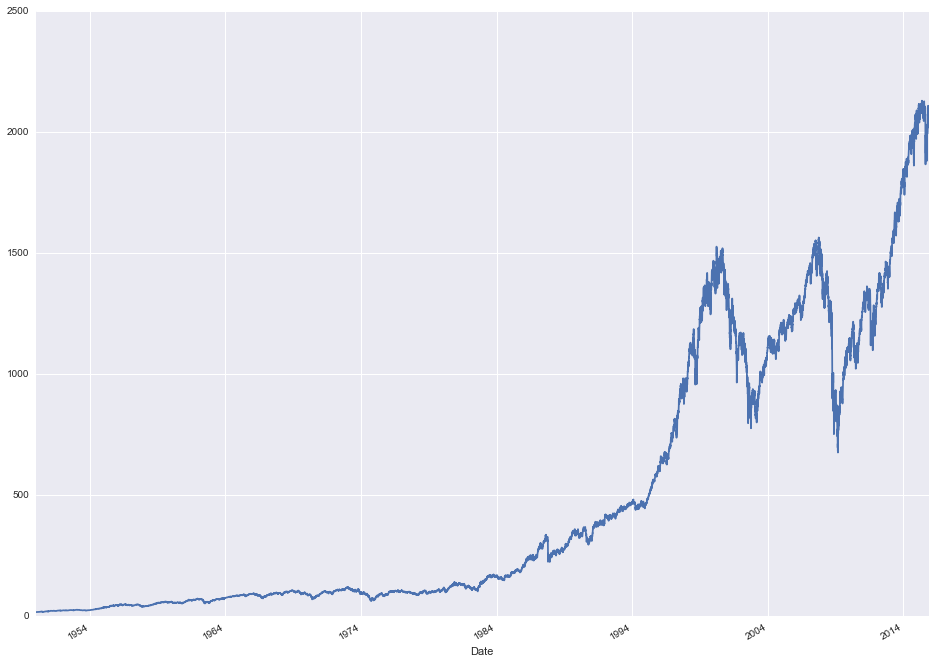

In [6]:
stock_data['Close'].plot(figsize=(16, 12))  

The first obvious thing to note, aside from the two giant dips at the tail end corresponding to the market crashes in 2002 and 2008, is that the data is clearly non-stationary. This makes sense for market data as it tends to go up in the long run more than it goes down. This is a problem for time series analysis though as non-stationary data is hard to reason about. The first thing we can try is a first difference of the series. In other words, subtract the previous value t-1 from the current value t to get the difference d(t).

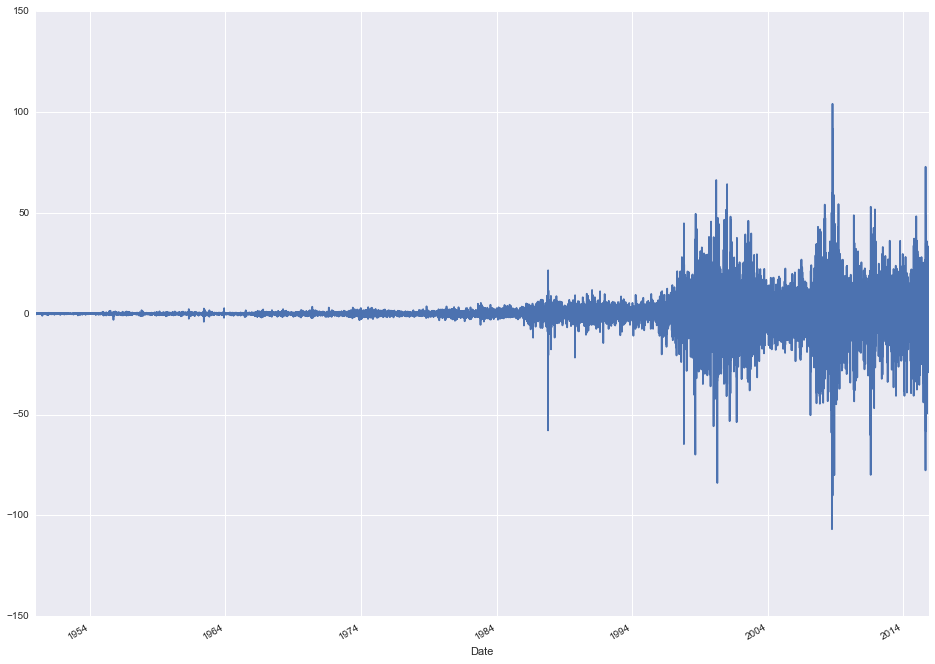

In [7]:
stock_data['First Difference'] = stock_data['Close'] - stock_data['Close'].shift()  
stock_data['First Difference'].plot(figsize=(16, 12))  

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

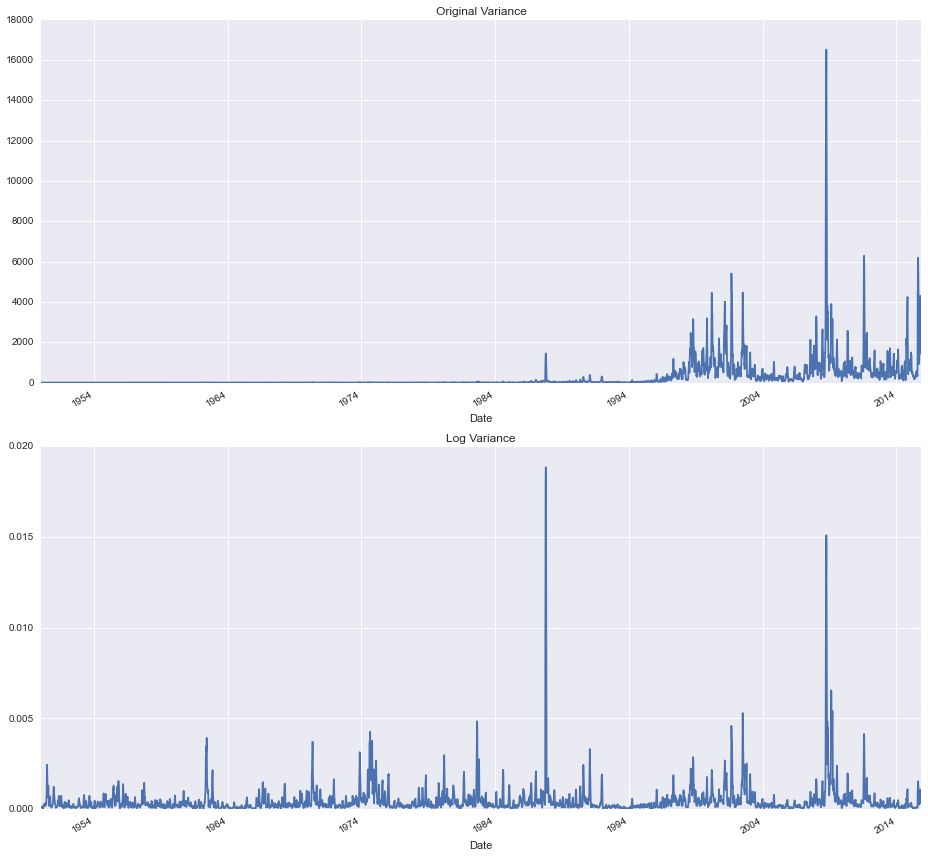

In [9]:
stock_data['Original Variance'] = pd.rolling_var(stock_data['Close'], 30, min_periods=None, freq=None, center=True)  
stock_data['Log Variance'] = pd.rolling_var(stock_data['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))  
stock_data['Original Variance'].plot(ax=ax[0], title='Original Variance')  
stock_data['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

Observe that in the top graph, we can't even see any of the variations until the late 80s. In the bottom graph however it's a different story, changes in the value are clearly visible throughout the entire data set. From this view, it's clear that our transformation has made the variance relatively constant.

Now we can see the earlier variations in the data set quite a bit better than before. We still need to take the first difference though so let's calculate that from the logged series.

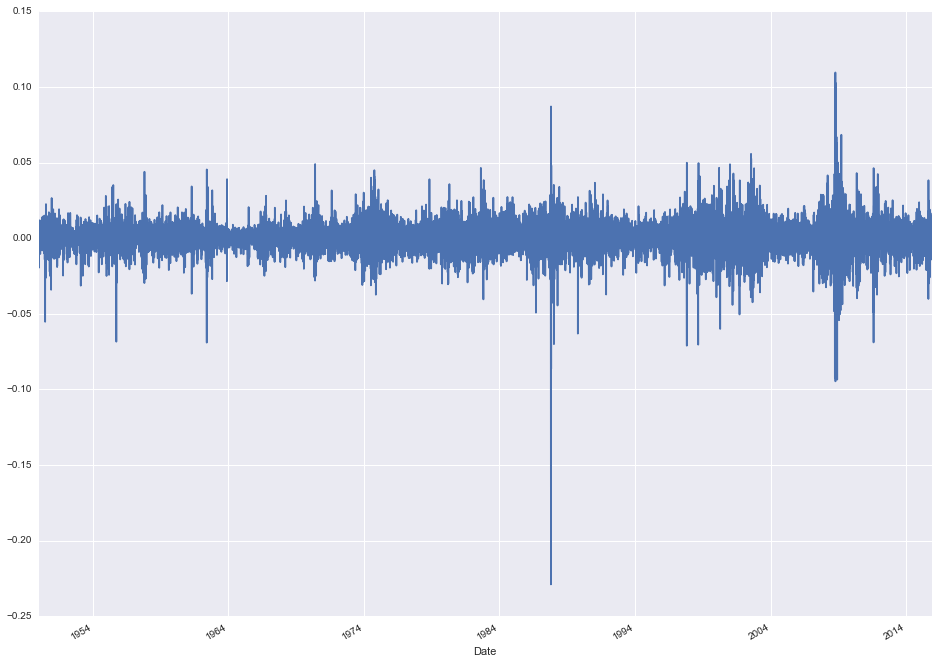

In [10]:
stock_data['Logged First Difference'] = stock_data['Natural Log'] - stock_data['Natural Log'].shift()  
stock_data['Logged First Difference'].plot(figsize=(16, 12))  

Much better! We now have a stationary time series model of daily changes to the S&P 500 index. Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

In [11]:
stock_data['Lag 1'] = stock_data['Logged First Difference'].shift()  
stock_data['Lag 2'] = stock_data['Logged First Difference'].shift(2)  
stock_data['Lag 5'] = stock_data['Logged First Difference'].shift(5)  
stock_data['Lag 30'] = stock_data['Logged First Difference'].shift(30)

One interesting visual way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable vs. the lagged variable and see where the distribution lies. We can do this with a joint plot using the seaborn package.



C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


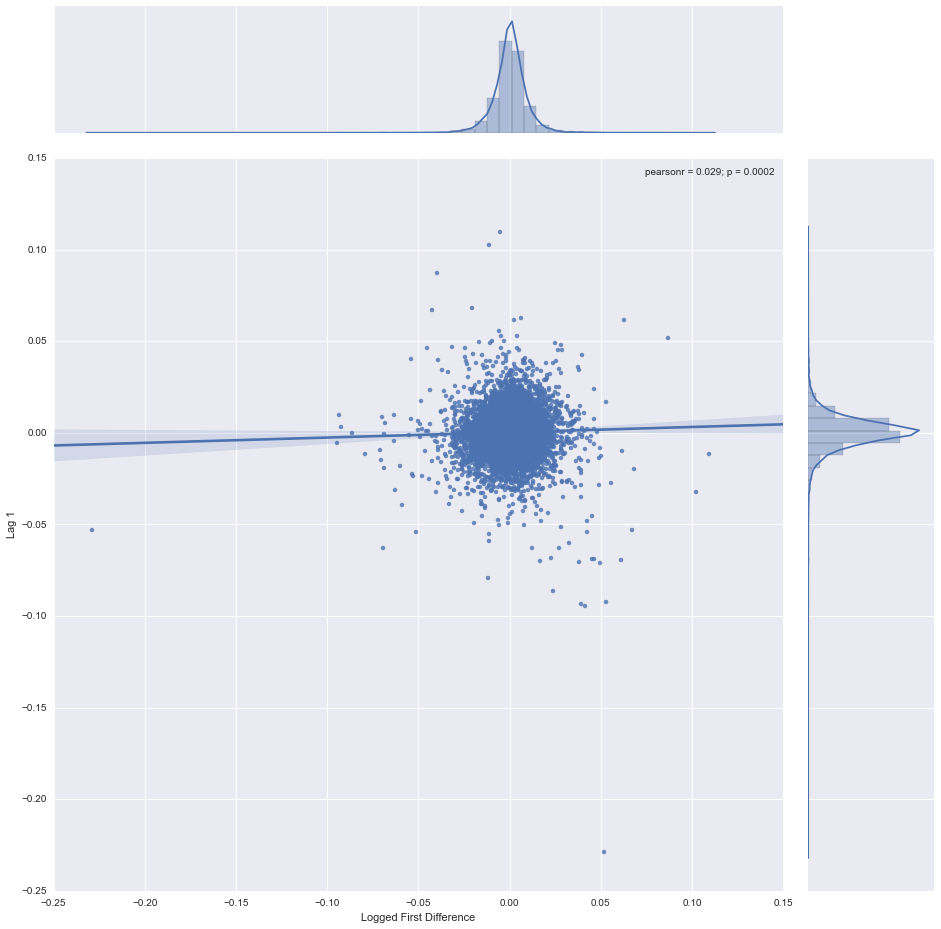

In [13]:
sb.jointplot('Logged First Difference', 'Lag 1', stock_data, kind='reg', size=13)  


Notice how tightly packed the mass is around 0. It also appears to be pretty evenly distributed - the marginal distributions on both axes are roughly normal. This seems to indicate that knowing the index value one day doesn't tell us much about what it will do the next day.

It probably comes as no surprise that there's very little correlation between the change in value from one day to the next. Although I didn't plot them out here, the other lagged variables that we created above show similar results. There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually. Fortunately there is a class of functions that can systematically do this for us.

In [14]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['Logged First Difference'].iloc[1:])  
lag_partial_correlations = pacf(stock_data['Logged First Difference'].iloc[1:]) 

The auto-correlation function computes the correlation between a variable and itself at each lag step up to some limit (in this case 40). The partial auto-correlation function computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps. We can plot the results to see if there are any significant correlations.

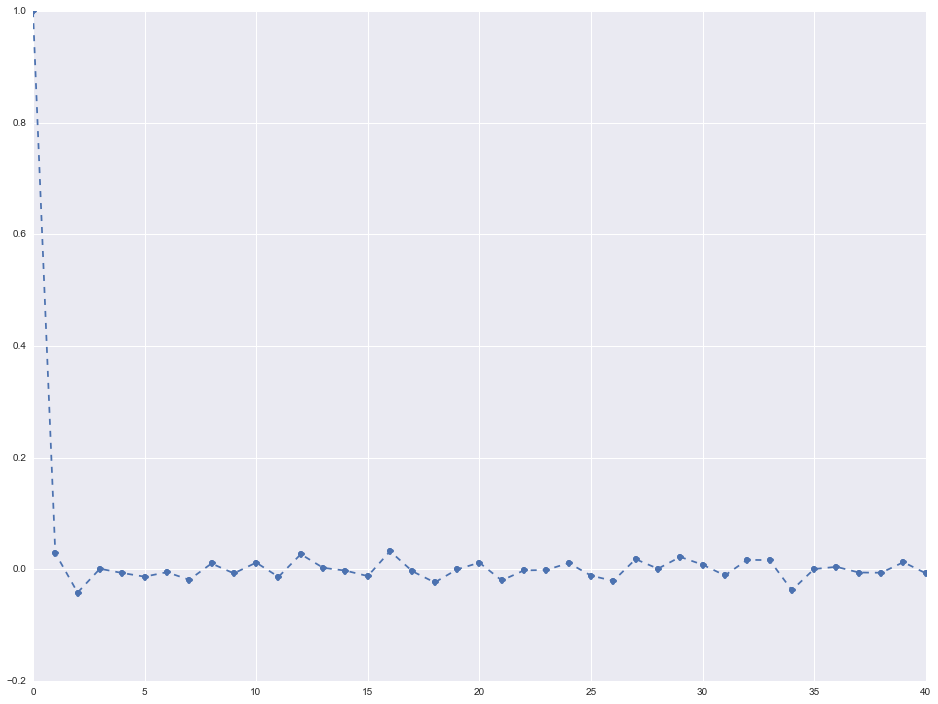

In [16]:
fig, ax = plt.subplots(figsize=(16,12))  
ax.plot(lag_correlations, marker='o', linestyle='--')  

The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above). What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk.

Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.

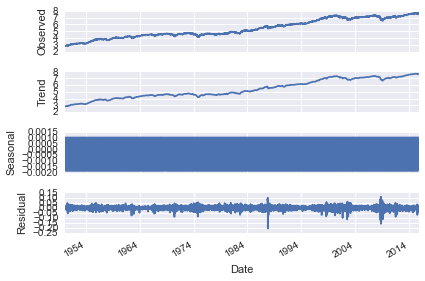

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Natural Log'], model='additive', freq=30)  
fig = plt.figure()  
fig = decomposition.plot()  

Since we don't see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal pattern though it can be very useful. The folling instance, for example, is a sample from the statsmodels documentation showing CO2 emissions data over time.



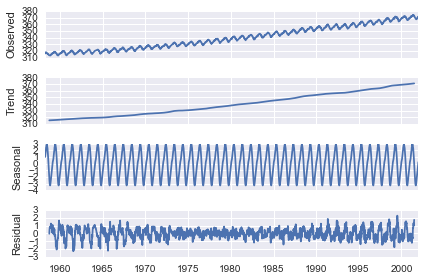

In [19]:
co2_data = sm.datasets.co2.load_pandas().data  
co2_data.co2.interpolate(inplace=True)  
result = sm.tsa.seasonal_decompose(co2_data.co2)  
fig = plt.figure()  
fig = result.plot()  

The decomposition is much more useful in this case. There are three clearly distinct components to the time series - a trend line, a seasonal adjustment, and residual values. Each of these would need to be accounted for and modeled appropriately.

Going back to our stock data, we're already observed that it's a random walk and that our lagged variables don't seem to have much impact, but we can still try fitting some ARIMA models and see what we get. Let's start with a simple moving average model.

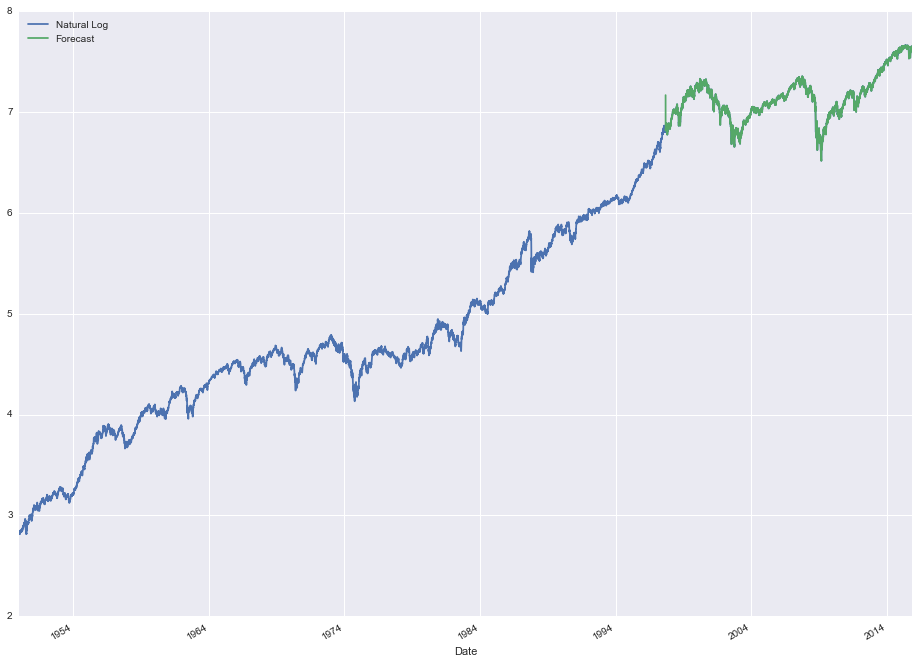

In [29]:
model = sm.tsa.ARIMA(stock_data['Natural Log'].iloc[12000:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
stock_data['Forecast'] = results.fittedvalues  
stock_data[['Natural Log', 'Forecast']].plot(figsize=(16, 12))  